## Package Initialization

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers as ppb

import warnings
import os.path as path

settings:

In [2]:
# print messages
warnings.filterwarnings('ignore')

# device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device type: {device.type}")

device type: cuda


## Import Dataset

The dataset we will use in this example is [SST2](https://nlp.stanford.edu/sentiment/index.html), which contains sentences from movie reviews, each labeled as either positive (has the value 1) or negative (has the value 0):

In [3]:
DATASET_DIR = "./data/sst2"

In [4]:
train_df = pd.read_csv(f"{DATASET_DIR}/train.tsv", delimiter = '\t', header = None)

train_df[1].value_counts()

1    3610
0    3310
Name: 1, dtype: int64

## Loading Pre-trained DistilBERT Model

In [7]:
# load pretrained model/tokenizer

# For DistilBERT:
tokenizer = ppb.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

## Tokenization

Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

In [8]:
tokenized = train_df[0].apply(lambda x: tokenizer.encode(x, add_special_tokens = True))

In [9]:
tokenized

0       [101, 1037, 18385, 1010, 6057, 1998, 2633, 182...
1       [101, 4593, 2128, 27241, 23931, 2013, 1996, 62...
2       [101, 2027, 3653, 23545, 2037, 4378, 24185, 10...
3       [101, 2023, 2003, 1037, 17453, 14726, 19379, 1...
4       [101, 5655, 6262, 1005, 1055, 12075, 2571, 376...
                              ...                        
6915    [101, 9145, 1010, 7570, 18752, 14116, 1998, 28...
6916    [101, 2202, 2729, 2003, 19957, 2864, 2011, 103...
6917    [101, 1996, 5896, 4472, 4121, 1010, 3082, 7832...
6918    [101, 1037, 5667, 2919, 2143, 2007, 5667, 2561...
6919    [101, 1037, 12090, 2135, 2512, 5054, 19570, 23...
Name: 0, Length: 6920, dtype: object

## Padding

In [10]:
# find max length among all sentences

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        
print(f"Max sentence length: {max_len}")

Max sentence length: 67


In [11]:
padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])
padded

array([[  101,  1037, 18385, ...,     0,     0,     0],
       [  101,  4593,  2128, ...,     0,     0,     0],
       [  101,  2027,  3653, ...,     0,     0,     0],
       ...,
       [  101,  1996,  5896, ...,     0,     0,     0],
       [  101,  1037,  5667, ...,     0,     0,     0],
       [  101,  1037, 12090, ...,     0,     0,     0]])

In [12]:
padded.shape

(6920, 67)

## Masking

If we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input.  
That's what *attention_mask* is:

In [13]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(6920, 67)

## Modeling: Using BERT to Embed All Input Sentences

In [15]:
BATCH_SIZE = 100

In [18]:
input_tensors = torch.tensor(padded).to(device)
attention_mask = torch.tensor(attention_mask).to(device)

example_n = input_tensors.shape[0]
features = torch.zeros((example_n, 768)).to(device)

# using pretrained model for embedding, it's not a part of training. so turn the auto rad off
with torch.no_grad():
    
    for i in range(0, example_n, BATCH_SIZE):
        
        END = (i + BATCH_SIZE) if (i + BATCH_SIZE < example_n) else (example_n)
        
        last_hidden_states = model(input_tensors[i:END], attention_mask = attention_mask[i:END] )
        
        # The embedded CLS token can be thought of as an embedding for the entire sentence!!
        features[i:END] = last_hidden_states[0][:, 0, :]

In [20]:
features.shape

torch.Size([6920, 768])

In [50]:
labels = torch.tensor(train_df[1].values, dtype=torch.float).to(device)
labels.shape

torch.Size([6920])

## Train/Test Split

In [24]:
TRAIN_TEST_RATIO = 0.75

In [51]:
# create shuffled indexs
perm = torch.randperm(example_n)

# indexs for training set
indexs = perm[ : int(example_n * TRAIN_TEST_RATIO)]

# indexs for test set
mask = torch.ones((example_n,), dtype=torch.bool)
mask[indexs] = 0

# training set
train_features = features[indexs]
train_labels = labels[indexs]

# test set
test_features = features[mask]
test_labels = labels[mask]

print(f"train_features.shape: {train_features.shape}")
print(f"train_labels.shape: {train_labels.shape}")

print(f"test_features.shape: {test_features.shape}")
print(f"test_labels.shape: {test_labels.shape}")

train_features.shape: torch.Size([5190, 768])
train_labels.shape: torch.Size([5190])
test_features.shape: torch.Size([1730, 768])
test_labels.shape: torch.Size([1730])


## Downstream Classification

In [72]:
LR = 0.001 # learning rate
EPOCH = 1000

In [85]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, input_dimension = 768):
        super(SentimentClassifier, self).__init__()
        self.linear = nn.Linear(input_dimension, 1)
        
    def forward(self, x):
        prediction = F.sigmoid(self.linear(x))
        
        return prediction

In [86]:
# create model instance

sentiment_classifier = SentimentClassifier(768).to(device)

# loss function: binary cross-entropy

criterion = torch.nn.BCELoss()

# create optimizer instance

optimizer = torch.optim.Adam(sentiment_classifier.parameters(), lr = LR)

In [88]:
epoch_losses = []
for epoch in range(EPOCH):
    
    batch_losses = []
    
    for i in range(0, train_features.size(0), BATCH_SIZE):
        
        optimizer.zero_grad()
        
        END = (i + BATCH_SIZE) if (i + BATCH_SIZE) < train_features.size(0) else train_features.size(0)
        
        batch = train_features[i:END]
    
        # forward
        predicted = sentiment_classifier(batch)
        
        # compute loss
        loss = criterion(predicted, train_labels[i:END].unsqueeze(1))
        
        # backward propagation
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss)
        
    epoch_losses.append(torch.tensor(batch_losses).mean().item())

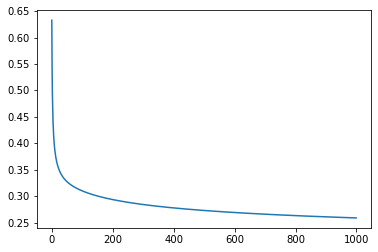

In [89]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.show()

## Evaluation

In [97]:
from sklearn.metrics import roc_auc_score

with torch.no_grad():
    
    test_predicted = sentiment_classifier(test_features).squeeze(1)
    
    roc_scores = roc_auc_score(test_labels.cpu(), test_predicted.cpu())
    
    print(f"ROC AUC score on test set: {roc_scores}")

ROC AUC score on test set: 0.9124356825969728
